In [2]:
import pandas as pd

# Load the uploaded file
data = pd.read_csv("hospital_readmissions.csv")

# Display the first few rows of the dataset to inspect its structure
data.head(), data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                25000 non-null  object
 1   time_in_hospital   25000 non-null  int64 
 2   n_lab_procedures   25000 non-null  int64 
 3   n_procedures       25000 non-null  int64 
 4   n_medications      25000 non-null  int64 
 5   n_outpatient       25000 non-null  int64 
 6   n_inpatient        25000 non-null  int64 
 7   n_emergency        25000 non-null  int64 
 8   medical_specialty  25000 non-null  object
 9   diag_1             25000 non-null  object
 10  diag_2             25000 non-null  object
 11  diag_3             25000 non-null  object
 12  glucose_test       25000 non-null  object
 13  A1Ctest            25000 non-null  object
 14  change             25000 non-null  object
 15  diabetes_med       25000 non-null  object
 16  readmitted         25000 non-null  objec

(       age  time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
 0  [70-80)                 8                72             1             18   
 1  [70-80)                 3                34             2             13   
 2  [50-60)                 5                45             0             18   
 3  [70-80)                 2                36             0             12   
 4  [60-70)                 1                42             0              7   
 
    n_outpatient  n_inpatient  n_emergency medical_specialty       diag_1  \
 0             2            0            0           Missing  Circulatory   
 1             0            0            0             Other        Other   
 2             0            0            0           Missing  Circulatory   
 3             1            0            0           Missing  Circulatory   
 4             0            0            0  InternalMedicine        Other   
 
         diag_2       diag_3 glucose_test A1Ctest chan

In [3]:
import numpy as np

# Step 1: Convert 'readmitted' to binary (1 for 'yes', 0 for 'no')
data['readmitted'] = data['readmitted'].map({'yes': 1, 'no': 0})

# Step 2: Convert 'age' ranges to numeric midpoints
age_mapping = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45,
    '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95
}
data['age'] = data['age'].map(age_mapping)

# Step 3: Check for missing values in the dataset
missing_values = data.isnull().sum()

# Step 4: Encode categorical columns
categorical_columns = ['medical_specialty', 'diag_1', 'diag_2', 'diag_3', 
                       'glucose_test', 'A1Ctest', 'change', 'diabetes_med']
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Display results
missing_values, data_encoded.head()


(age                  0
 time_in_hospital     0
 n_lab_procedures     0
 n_procedures         0
 n_medications        0
 n_outpatient         0
 n_inpatient          0
 n_emergency          0
 medical_specialty    0
 diag_1               0
 diag_2               0
 diag_3               0
 glucose_test         0
 A1Ctest              0
 change               0
 diabetes_med         0
 readmitted           0
 dtype: int64,
    age  time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
 0   75                 8                72             1             18   
 1   75                 3                34             2             13   
 2   55                 5                45             0             18   
 3   75                 2                36             0             12   
 4   65                 1                42             0              7   
 
    n_outpatient  n_inpatient  n_emergency  readmitted  \
 0             2            0            0           0   
 1 

In [5]:
! pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/124.9 MB 1.9 MB/s eta 0:01:07
   ---------------------------------------- 0.8/124.9 MB 1.9 MB/s eta 0:01:07
   ---------------------------------------- 0.8/124.9 MB 1.9 MB/s eta 0:01:07
    --------------------------------------- 1.6/124.9 MB 1.6 MB/s eta 0:01:20
    --------------------------------------- 1.8/124.9 MB 1.6 MB/s eta 0:01:17
    --------------------------------------- 2.1/124.9 MB 1.7 MB/s eta 0:01:15
    --------------------------------------- 2.1/124.9 MB 1.7 MB/s eta 0:01:15
    --------------------------------------- 2.6/124.9 MB 1.6 MB/s eta 0:01:19
    --------------------------------------- 2.9/124.9 MB 1.5 MB/s eta 0:01:23
    ---

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Step 1: Define features (X) and target (y)
X = data_encoded.drop(columns=['readmitted'])
y = data_encoded['readmitted']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Train Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Train Random Forest model
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

# Train XGBoost model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

# Step 3: Evaluate Models
models = {"Logistic Regression": logreg, "Random Forest": rf, "XGBoost": xgb}
results = {}

for name, model in models.items():
    # Predict on the test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calculate ROC-AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    results[name] = {
        "Confusion Matrix": confusion_matrix(y_test, y_pred),
        "Classification Report": classification_report(y_test, y_pred),
        "ROC-AUC": roc_auc,
    }

results


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [08:19:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


{'Logistic Regression': {'Confusion Matrix': array([[2076,  573],
         [1368,  983]]),
  'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.60      0.78      0.68      2649\n           1       0.63      0.42      0.50      2351\n\n    accuracy                           0.61      5000\n   macro avg       0.62      0.60      0.59      5000\nweighted avg       0.62      0.61      0.60      5000\n',
  'ROC-AUC': np.float64(0.6441399280869533)},
 'Random Forest': {'Confusion Matrix': array([[1819,  830],
         [1164, 1187]]),
  'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.61      0.69      0.65      2649\n           1       0.59      0.50      0.54      2351\n\n    accuracy                           0.60      5000\n   macro avg       0.60      0.60      0.59      5000\nweighted avg       0.60      0.60      0.60      5000\n',
  'ROC-AUC': np.float64(0.6275949978475541)},
 '

In [7]:
# Display detailed evaluation metrics for each model
formatted_results = {}

for name, metrics in results.items():
    cm = metrics["Confusion Matrix"]
    report = metrics["Classification Report"]
    roc_auc = metrics["ROC-AUC"]
    
    formatted_results[name] = {
        "Confusion Matrix": cm,
        "Classification Report": report,
        "ROC-AUC Score": roc_auc,
    }

formatted_results


{'Logistic Regression': {'Confusion Matrix': array([[2076,  573],
         [1368,  983]]),
  'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.60      0.78      0.68      2649\n           1       0.63      0.42      0.50      2351\n\n    accuracy                           0.61      5000\n   macro avg       0.62      0.60      0.59      5000\nweighted avg       0.62      0.61      0.60      5000\n',
  'ROC-AUC Score': np.float64(0.6441399280869533)},
 'Random Forest': {'Confusion Matrix': array([[1819,  830],
         [1164, 1187]]),
  'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.61      0.69      0.65      2649\n           1       0.59      0.50      0.54      2351\n\n    accuracy                           0.60      5000\n   macro avg       0.60      0.60      0.59      5000\nweighted avg       0.60      0.60      0.60      5000\n',
  'ROC-AUC Score': np.float64(0.6275949978

In [8]:
from sklearn.model_selection import GridSearchCV

# Step 1: Hyperparameter tuning for Logistic Regression
logreg_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],  # Limited to 'l2' due to solvers compatibility
}
logreg_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), logreg_params, scoring='roc_auc', cv=5)
logreg_grid.fit(X_train, y_train)

# Step 2: Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, scoring='roc_auc', cv=5)
rf_grid.fit(X_train, y_train)

# Step 3: Hyperparameter tuning for XGBoost
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
}
xgb_grid = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), 
                        xgb_params, scoring='roc_auc', cv=5)
xgb_grid.fit(X_train, y_train)

# Collect the best parameters and scores
optimized_results = {
    "Logistic Regression": {
        "Best Parameters": logreg_grid.best_params_,
        "Best Score": logreg_grid.best_score_,
    },
    "Random Forest": {
        "Best Parameters": rf_grid.best_params_,
        "Best Score": rf_grid.best_score_,
    },
    "XGBoost": {
        "Best Parameters": xgb_grid.best_params_,
        "Best Score": xgb_grid.best_score_,
    },
}

optimized_results


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/mod

{'Logistic Regression': {'Best Parameters': {'C': 0.01, 'penalty': 'l2'},
  'Best Score': np.float64(0.6472128799820452)},
 'Random Forest': {'Best Parameters': {'max_depth': 10,
   'min_samples_split': 5,
   'n_estimators': 200},
  'Best Score': np.float64(0.6602723788466688)},
 'XGBoost': {'Best Parameters': {'learning_rate': 0.1,
   'max_depth': 3,
   'n_estimators': 200},
  'Best Score': np.float64(0.6607745335412214)}}

In [9]:
# Step 1: Evaluate optimized models on the test set
optimized_models = {
    "Logistic Regression": logreg_grid.best_estimator_,
    "Random Forest": rf_grid.best_estimator_,
    "XGBoost": xgb_grid.best_estimator_,
}

test_results = {}

for name, model in optimized_models.items():
    # Predict on the test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calculate ROC-AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    test_results[name] = {
        "Confusion Matrix": cm,
        "Classification Report": report,
        "ROC-AUC": roc_auc,
    }

# Step 2: Extract feature importance for Random Forest and XGBoost
feature_importance = {
    "Random Forest": rf_grid.best_estimator_.feature_importances_,
    "XGBoost": xgb_grid.best_estimator_.feature_importances_,
}
feature_names = X.columns

# Combine feature names with their importance scores
rf_importance = sorted(zip(feature_names, feature_importance["Random Forest"]), key=lambda x: x[1], reverse=True)
xgb_importance = sorted(zip(feature_names, feature_importance["XGBoost"]), key=lambda x: x[1], reverse=True)

test_results, rf_importance[:10], xgb_importance[:10]



({'Logistic Regression': {'Confusion Matrix': array([[2101,  548],
          [1394,  957]]),
   'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.60      0.79      0.68      2649\n           1       0.64      0.41      0.50      2351\n\n    accuracy                           0.61      5000\n   macro avg       0.62      0.60      0.59      5000\nweighted avg       0.62      0.61      0.60      5000\n',
   'ROC-AUC': np.float64(0.6466481978625194)},
  'Random Forest': {'Confusion Matrix': array([[1971,  678],
          [1236, 1115]]),
   'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.61      0.74      0.67      2649\n           1       0.62      0.47      0.54      2351\n\n    accuracy                           0.62      5000\n   macro avg       0.62      0.61      0.61      5000\nweighted avg       0.62      0.62      0.61      5000\n',
   'ROC-AUC': np.float64(0.65432297991633

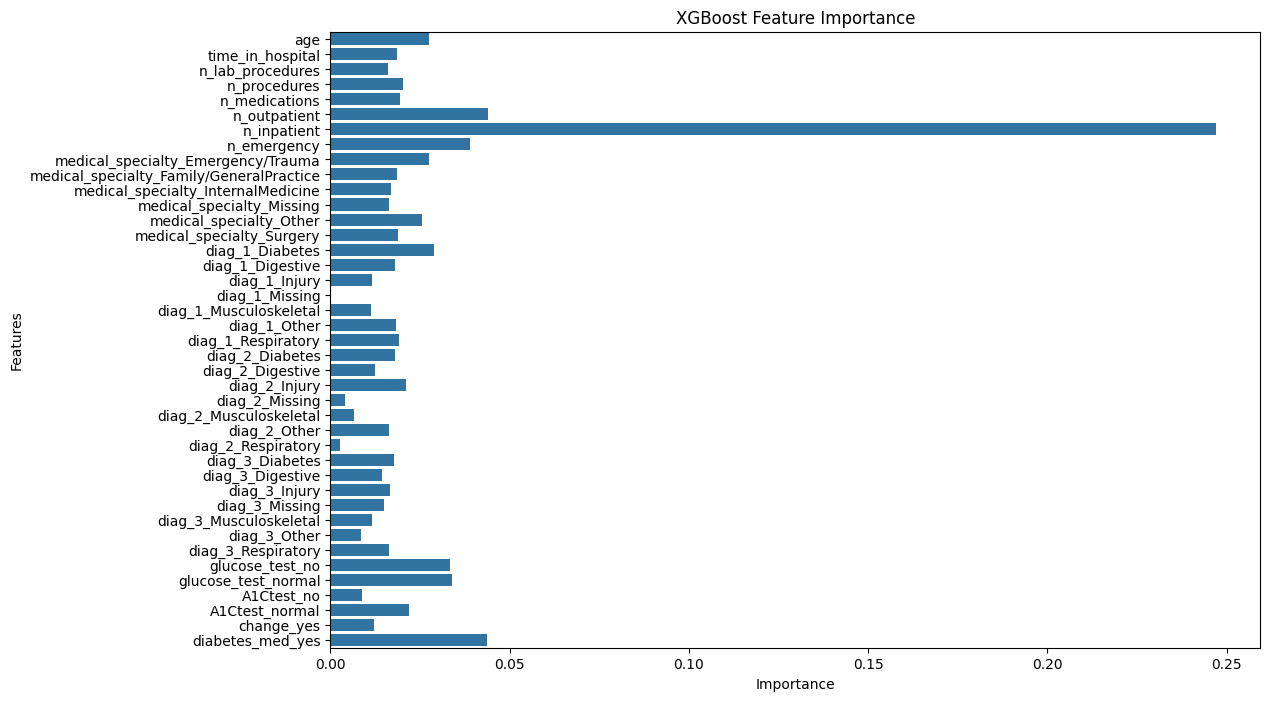

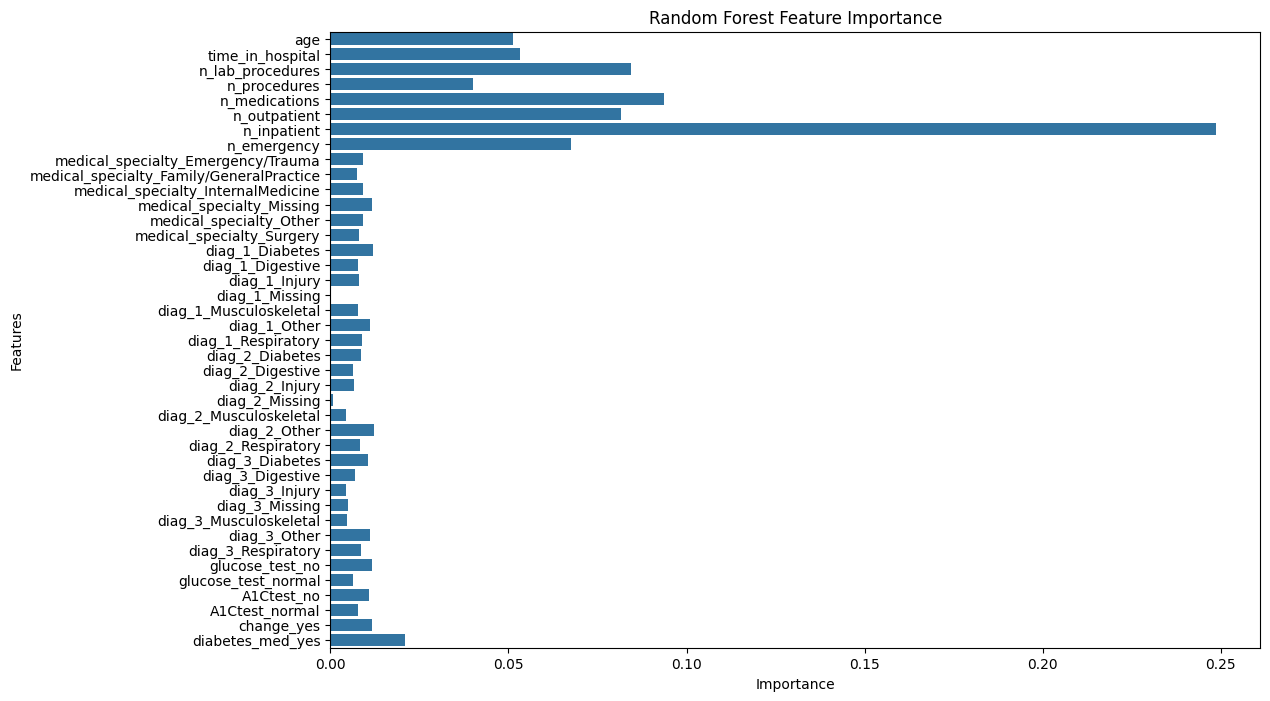

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Importance for XGBoost
xgb_importance = xgb_grid.best_estimator_.feature_importances_
xgb_features = X.columns

# Plotting XGBoost Feature Importance
plt.figure(figsize=(12, 8))
sns.barplot(x=xgb_importance, y=xgb_features)
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Feature Importance for Random Forest
rf_importance = rf_grid.best_estimator_.feature_importances_

# Plotting Random Forest Feature Importance
plt.figure(figsize=(12, 8))
sns.barplot(x=rf_importance, y=feature_names)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()
